In [2]:
import os                                                                       
from multiprocessing import Pool
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import fiona, geopy, timeit
from geopy.exc import GeocoderTimedOut
from shapely.geometry import Point

In [5]:
def do_geocode(address):
    try:
        return geolocator.geocode(address, timeout=1)
    except GeocoderTimedOut:
        return 'Geocoder timed out'

In [3]:
path_evict= r'/Users/raphaellaude/Documents/Work/wxy/evictions'

geolocator= geopy.geocoders.GoogleV3(api_key='XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX')

evicts= pd.read_csv(os.path.join(path_evict, 'Evictions.csv'))

In [4]:
addresses= (evicts['EVICTION_ADDRESS']+' '+evicts['BOROUGH']+' '+evicts['EVICTION_ZIP'].astype(str)).unique()

In [7]:
addresses.shape[0]

31195

In [8]:
31195/3

10398.333333333334

In [10]:
10399+10398+10398

31195

In [11]:
10399+10398

20796

In [16]:
addresses[2:4]

array(['1408 EAST 103RD STRE ET BROOKLYN 11236',
       '1035 BOYNTON AVENUE BRONX 10472'], dtype=object)

In [46]:
def geocode_addresses(r):
    toogeocode= {}
    
    for a in addresses[r[0]:r[1]]:
        toogeocode[a]= do_geocode(a)
    
    return toogeocode

In [55]:
processes= [[0, 1000], [1000, 2000], [2000, 3000], [3000, 4000]]

In [56]:
pool= Pool(processes=4)

In [57]:
start= timeit.default_timer()

results= pool.map(geocode_addresses, processes)

stop= timeit.default_timer()
print('Time: ', stop - start)

Time:  499.81521225100005


In [60]:
results[0]

{'2255 BARKER AVENUE BRONX 10467': Location(2255 Barker Ave, Bronx, NY 10467, USA, (40.8590381, -73.869702, 0.0)),
 '355 EAST 187TH ST BRONX 10458': Location(355 E 187th St, Bronx, NY 10458, USA, (40.859964, -73.894662, 0.0)),
 '1408 EAST 103RD STRE ET BROOKLYN 11236': Location(1408 E 103rd St, Brooklyn, NY 11236, USA, (40.6380127, -73.887101, 0.0)),
 '1035 BOYNTON AVENUE BRONX 10472': Location(1035 Boynton Ave, Bronx, NY 10472, USA, (40.8248821, -73.8776035, 0.0)),
 '3613 AVENUE D BROOKLYN 11203': Location(3613 Avenue D, Brooklyn, NY 11203, USA, (40.6416256, -73.94209000000001, 0.0)),
 '1014 NELSON AVENUE BRONX 10452': Location(1014 Nelson Ave, Bronx, NY 10452, USA, (40.83309, -73.9282549, 0.0)),
 '2102 NEEDHAM AVENUE BRONX 10466': Location(2102 Needham Ave, Bronx, NY 10466, USA, (40.883406, -73.83547899999999, 0.0)),
 '2380 RYER AVENUE BRONX 10458': Location(2380 Ryer Ave, Bronx, NY 10458, USA, (40.8593231, -73.8978971, 0.0)),
 '1201 EAST 233RD STREET BRONX 10462': Location(1201 E 23

In [78]:
outputs= pd.concat([pd.DataFrame(result) for result in results], sort=False, axis='columns')

In [83]:
geocoded= outputs.T.reset_index()

In [85]:
geocoded.columns= ['FULL_ADDRESS', 'google_address', 'lng_lat']

# merge

In [82]:
evicts['FULL_ADDRESS']= evicts['EVICTION_ADDRESS']+' '+evicts['BOROUGH']+' '+evicts['EVICTION_ZIP'].astype(str)

In [90]:
coded_evicts= pd.merge(evicts, geocoded, on='FULL_ADDRESS')

In [87]:
evicts.shape

(48317, 12)

In [91]:
coded_evicts.shape

(7432, 14)

In [107]:
coded_evicts['geometry']= coded_evicts[~coded_evicts['lng_lat'].isna()]['lng_lat'].apply(lambda x: Point(x[::-1]))

In [113]:
coded_evicts[coded_evicts['geometry'].isna()].index

Int64Index([4830], dtype='int64')

In [94]:
coded_evicts['lng_lat'].dtype

dtype('O')

In [109]:
coded_evicts= gpd.GeoDataFrame(coded_evicts)

In [110]:
coded_evicts.crs= fiona.crs.from_epsg(4326)

In [114]:
coded_evicts.drop(4830, inplace=True)

In [115]:
coded_evicts= coded_evicts.to_crs(epsg=2263)

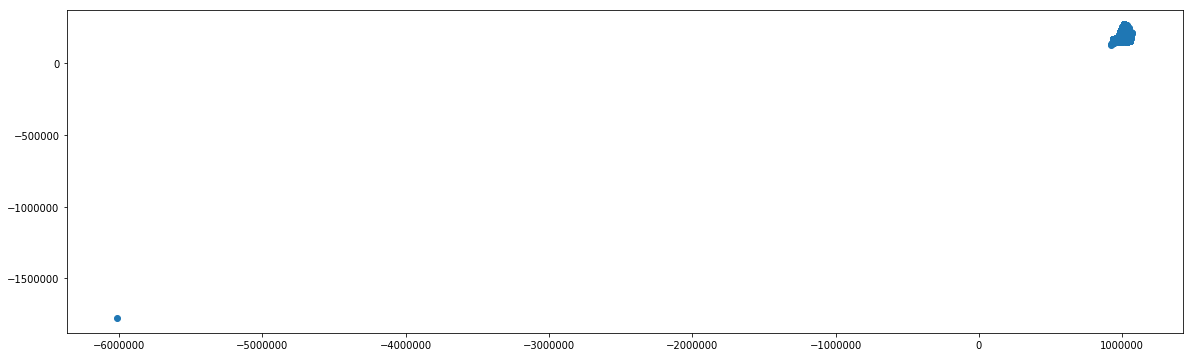

In [119]:
coded_evicts.plot(figsize=(20,20))
plt.show();

In [120]:
path_exp= r'/Users/raphaellaude/Documents/Work/wxy/evictions'

In [122]:
coded_evicts.columns

Index(['COURT_INDEX_NUMBER', 'DOCKET_NUMBER', 'EVICTION_ADDRESS',
       'EVICTION_APT_NUM', 'EXECUTED_DATE', 'MARSHAL_FIRST_NAME',
       'MARSHAL_LAST_NAME', 'RESIDENTIAL_COMMERCIAL_IND', 'BOROUGH',
       'EVICTION_ZIP', 'SCHEDULE_STATUS', 'FULL_ADDRESS', 'google_address',
       'lng_lat', 'geometry'],
      dtype='object')

In [124]:
coded_evicts[[c for c in coded_evicts.columns if c not in ['lng_lat']]].to_file(os.path.join(path_exp, 'sample_evictions.shp'))

# failed from other process

In [125]:
failed= pd.read_csv(os.path.join(path_evict, 'Failed_Geocodings.csv'))

In [126]:
f_addrs= failed['FULL_ADDRESS'].values

In [127]:
f_addrs

array(['154 NORMAN AVENUE 120 NEWEL STREET BROOKLYN 11222',
       '293 MYRTLE AVENUE BUILDING NO. 37 STORE 11 BROOKLYN 11205',
       '142 ADA DRIVE  ENTIRE PREMISES STATEN ISLAND 10314', ...,
       '2051 ST. RAYMOND AVENUE BRONX 10462',
       '89 SACKMAN STREET BROOKLYN 11233',
       '106 HOPKINSON AVENUE - APT 4 BROOKLYN 11233'], dtype=object)

In [128]:
len(f_addrs)

1947

In [134]:
processes2= [[0, 487], [487, 974], [974, 1461], [1461, 1947]]

In [156]:
def geocode_addresses2(r):
    toogeocode= {}
    
    for a in f_addrs[r[0]:r[1]]:
        toogeocode[a]= do_geocode(a)
    
    return toogeocode

In [157]:
pool2= Pool(processes=4)

start= timeit.default_timer()

results2= pool2.map(geocode_addresses2, processes2)

stop= timeit.default_timer()
print('Time: ', stop - start)

Time:  229.3464494279997


In [158]:
outputs2= pd.concat([pd.DataFrame(result) for result in results2], sort=False, axis='columns').T.reset_index()\
.rename(columns={'index':'FULL_ADDRESS', 0:'google_addr', 1:'lng_lat'})

In [159]:
outputs2

,FULL_ADDRESS,google_addr,lng_lat
0,154 NORMAN AVENUE 120 NEWEL STREET BROOKLYN 11222,None,None
1,293 MYRTLE AVENUE BUILDING NO. 37 STORE 11 BRO...,None,None
2,142 ADA DRIVE ENTIRE PREMISES STATEN ISLAND 1...,"142 Ada Dr, Staten Island, NY 10314, USA","(40.6203875, -74.1590787)"
3,623 SACKETT STREET COMMERCIAL STORE BROOKLYN ...,None,None
4,547 W 145TH STREET UNIT B MANHATTAN 10031,None,None
5,2855 WHITE PLAINS RD IN THE BLDG 2853-65 WHITE...,None,None
6,42-87 MAIN STREET 3RD FLOOR QUEENS 11355,None,None
7,3 JACKSON PARK AKA 28-10 JACKSON AVENUE QUEENS...,None,None
8,215-05 NORTHERN BLVD UNIT: 2ND STORE TO THE LE...,None,None
9,42-79 MAIN STREET 2ND FLOOR QUEENS 11355,None,None


In [160]:
coded_evicts2= pd.merge(evicts, outputs2, on='FULL_ADDRESS')

In [165]:
coded_evicts2['geometry']= coded_evicts2[(~(coded_evicts2['lng_lat'].isna()))&
                                         (~(coded_evicts2['lng_lat']=='Geocoder timed out'))]\
['lng_lat'].apply(lambda x: Point(x[::-1]))

In [166]:
coded_evicts2= gpd.GeoDataFrame(coded_evicts2)

In [167]:
coded_evicts2.crs= fiona.crs.from_epsg(4326)

In [168]:
coded_evicts2_withgeo= coded_evicts2[~coded_evicts2['geometry'].isna()].to_crs(epsg=2263)

In [169]:
coded_evicts2_withgeo

,COURT_INDEX_NUMBER,DOCKET_NUMBER,EVICTION_ADDRESS,EVICTION_APT_NUM,EXECUTED_DATE,MARSHAL_FIRST_NAME,MARSHAL_LAST_NAME,RESIDENTIAL_COMMERCIAL_IND,BOROUGH,EVICTION_ZIP,SCHEDULE_STATUS,FULL_ADDRESS,google_addr,lng_lat,geometry
2,R 53522/16,68681,142 ADA DRIVE ENTIRE PREMISES,NaN,08/08/2017,Steven,Powell,Residential,STATEN ISLAND,10314,Scheduled,142 ADA DRIVE ENTIRE PREMISES STATEN ISLAND 1...,"142 Ada Dr, Staten Island, NY 10314, USA","(40.6203875, -74.1590787)",POINT (940087.8767427296 165340.3761554212)
3,R 53522\16,68682,142 ADA DRIVE ENTIRE PREMISES,NaN,08/08/2017,Steven,Powell,Residential,STATEN ISLAND,10314,Scheduled,142 ADA DRIVE ENTIRE PREMISES STATEN ISLAND 1...,"142 Ada Dr, Staten Island, NY 10314, USA","(40.6203875, -74.1590787)",POINT (940087.8767427296 165340.3761554212)
12,11621/16,4512,107-59 159TH STREET,03B,10/31/2017,Edward,Guida,Residential,QUEENS,11433,Scheduled,107-59 159TH STREET QUEENS 11433,"107-59 159th St, Jamaica, NY 11433, USA","(40.6956455, -73.793925)",POINT (1041394.326117682 192786.0823986308)
13,79334/18,90705,222 EAST 19TH STREET,8-H,02/28/2019,Justin,Grossman,Residential,MANHATTAN,10003,Scheduled,222 EAST 19TH STREET MANHATTAN 10003,"222 E 19th St, New York, NY 10003, USA","(40.7357356, -73.9838813)",POINT (988717.0107333009 207325.322441532)
14,K85177/16,76350,3602 CLARENDON ROAD A/K/A 1221 BROOKLYN,1R,06/22/2017,Ileana,Rivera,Residential,BROOKLYN,11203,Scheduled,3602 CLARENDON ROAD A/K/A 1221 BROOKLYN BROOKL...,"3602 Clarendon Rd, Brooklyn, NY 11203, USA","(40.6433896, -73.9427929)",POINT (1000125.900339628 173685.7422582904)
15,70473/17,203805,149-25 88TH STREET,NaN,01/12/2018,Richard,Capuano,Residential,QUEENS,11414,Scheduled,149-25 88TH STREET QUEENS 11414,"149-25 88th St, Jamaica, NY 11414, USA","(40.669027, -73.84684299999999)",POINT (1026737.207945473 183058.1186127717)
16,93491/18,91489,287 HARMAN STREET,1L,02/20/2019,Henry,Daley,Residential,BROOKLYN,11237,Scheduled,287 HARMAN STREET BROOKLYN 11237,"287 Harman St, Brooklyn, NY 11237, USA","(40.6998114, -73.919219)",POINT (1006649.082747197 194246.9544219286)
17,25980/17,65158,210 WEST 262ND STREE T A/K/A 6653 BROADWAY,4-E,07/13/2017,Justin,Grossman,Residential,BRONX,10471,Scheduled,210 WEST 262ND STREE T A/K/A 6653 BROADWAY BRO...,"210 W 262nd St, Bronx, NY 10471, USA","(40.9102107, -73.89739039999999)",POINT (1012611.955657084 270909.1638926408)
18,57317/17,7365,194-30 D 65TH CRESEN T,D,06/12/2017,George,"Essock, Jr.",Residential,QUEENS,11365,Scheduled,194-30 D 65TH CRESEN T QUEENS 11365,"194-30D 65th Crescent, Fresh Meadows, NY 11365...","(40.7397899, -73.77848929999999)",POINT (1045633.946504725 208879.6330837018)
19,83021/17,5557,470 EAST 40TH STREET WALK IN BASMNT 1ST,1,12/08/2017,Frank,Siracusa,Residential,BROOKLYN,11203,Scheduled,470 EAST 40TH STREET WALK IN BASMNT 1ST BROOK...,"470 E 40th St BASEMENT 1ST, Brooklyn, NY 11203...","(40.6442594, -73.9395412)",POINT (1001028.081101443 174003.2401368755)


In [170]:
coded_evicts2_withgeo[[c for c in coded_evicts2_withgeo.columns if c not in ['lng_lat']]]\
.to_file(os.path.join(path_exp, 'extra_evictions.shp'))

/Users/raphaellaude/anaconda3/lib/python3.7/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
